In [3]:
import os
import pandas as pd
import numpy as np
import scipy as sts
import matplotlib.pyplot as plt
import gmaps
import scipy.stats as st 
import seaborn as sns 

In [4]:
world_df= pd.read_csv("../Resources/owid-covid-data.csv")


updated_world_df=world_df.drop(["iso_code", "total_cases", "new_cases","new_deaths_per_million","total_tests","new_tests",
                                "new_tests_smoothed_per_thousand","population","median_age","aged_70_older",
                                "extreme_poverty","diabetes_prevalence","female_smokers","male_smokers",
                               "handwashing_facilities","hospital_beds_per_thousand","life_expectancy",
                               "new_tests_smoothed","new_tests_per_thousand","tests_units","total_deaths",
                               "new_deaths","total_cases_per_million","new_cases_per_million"], axis=1)

updated_world_df=updated_world_dfupdated_world_df=updated_world_df.rename(columns={"location":"Country", "continent":"Continent","date":"Date",
                                                  "total_deaths_per_million":"Total Deaths Per Million",
                                                  "total_tests_per_thousand":"Total Test Per Thousands",
                                                 "population_density":"Population Density","aged_65_older":"Aged 65 or older",
                                                 "gdp_per_capita":"GDP Per Capita","cvd_death_rate":"Covid Death Rate",
                                                 "stringency_index":"Stringency Index"})

#updated_world_df.fillna(0, inplace=True)

updated_world_df.head()

,Continent,Country,Date,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate
0,Asia,Afghanistan,2019-12-31,0.0,NaN,NaN,54.422,2.581,1803.987,597.029
1,Asia,Afghanistan,2020-01-01,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
2,Asia,Afghanistan,2020-01-02,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
3,Asia,Afghanistan,2020-01-03,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
4,Asia,Afghanistan,2020-01-04,0.0,NaN,0.0,54.422,2.581,1803.987,597.029


In [5]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

,Country,School Status,Latitude,Longitude,Income Level
0,Eritrea,Closed,15.9820,38.0200,Low income
1,Guinea-Bissau,Closed,12.1910,-14.4750,Low income
2,San Marino,Closed,43.9420,12.4611,High income
3,Georgia,Closed,42.0500,43.5760,Upper middle income
4,Italy,Closed,44.3713,11.1084,High income


The number of hospital beds per 10k people has a weak positive correlation with the total deaths per million of 0.43816367157071795


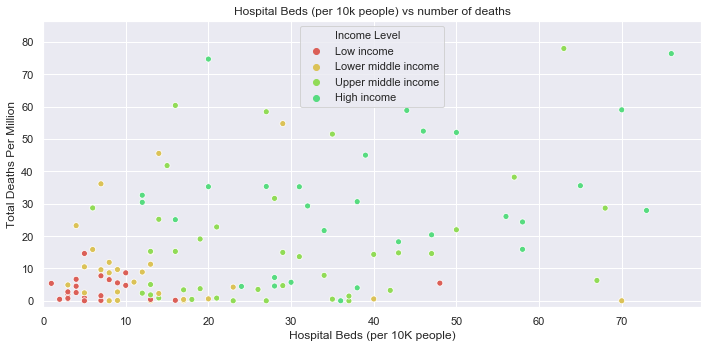

In [6]:
#Number Hospital Beds is based on the lastest year per Country

data = pd.read_csv("../Resources/data.csv")

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

sorted_date_df = updated_world_df.loc[updated_world_df["Date"] == "2020-06-21"]
sorted_date_df.head()

beds_vs_deaths = pd.merge(hospital_beds_df, sorted_date_df, on = "Country")
complete_data = pd.merge(beds_vs_deaths, income_df, on = "Country")
complete_data.head()

#removing outliers from view 
beds_q1 = complete_data["Hospital Beds (per 10K people)"].quantile(0.25)
beds_q3 = complete_data["Hospital Beds (per 10K people)"].quantile(0.75)
beds_iqr = beds_q3 - beds_q1
beds_lowerbound = beds_q1 - (1.5 * beds_iqr)
beds_upperbound = beds_q3 + (1.5 * beds_iqr)


deaths_q1 = complete_data["Total Deaths Per Million"].quantile(0.25)
deaths_q3 = complete_data["Total Deaths Per Million"].quantile(0.75)
deaths_iqr = deaths_q3 - deaths_q1
deaths_lowerbound = deaths_q1 - (1.5 *deaths_iqr)
deaths_upperbound = deaths_q3 + (1.5 * deaths_iqr)

indexnames = complete_data[complete_data["Total Deaths Per Million"] >= deaths_upperbound].index
dropped_outliers_df = complete_data.drop(indexnames, inplace = True)

indexnames2 = complete_data[complete_data["Hospital Beds (per 10K people)"] >= beds_upperbound].index
dropped_outliers2_df = complete_data.drop(indexnames2, inplace = True)

sns.set()
with sns.color_palette("hls", 8):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data = complete_data, x = "Hospital Beds (per 10K people)", y = "Total Deaths Per Million", hue = "Income Level", hue_order = ["Low income", "Lower middle income", "Upper middle income", "High income"])
    plt.title("Hospital Beds (per 10k people) vs number of deaths")
    plt.xlim(0,beds_upperbound)
    plt.ylim(-2 ,deaths_upperbound)
    plt.tight_layout()

#sns.regplot(x = complete_data["Hospital Beds (per 10K people)"], y = complete_data["Total Deaths Per Million"])
correlation = st.pearsonr(complete_data["Hospital Beds (per 10K people)"],complete_data["Total Deaths Per Million"])
print(f"The number of hospital beds per 10k people has a weak positive correlation with the total deaths per million of {correlation[0]}")
#complete_data.head()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


NameError: name 'deaths2_upperbound' is not defined

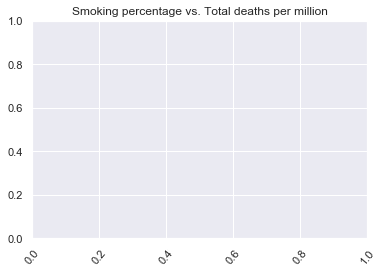

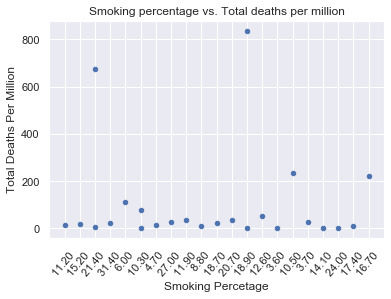

In [11]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

smoking_vs_deaths = pd.merge(smoking_df, sorted_date_df, on = "Country")
clean_smoking_vs_deaths = smoking_vs_deaths.dropna(subset = ["Smoking Percetage"])
plt.xticks(rotation=50)
plt.title("Smoking percentage vs. Total deaths per million")

#remove outliers 

smoking_vs_deaths = pd.merge(smoking_df, sorted_date_df, on = "Country")
clean_smoking_vs_deaths = smoking_vs_deaths.dropna(subset = ["Smoking Percetage"])
clean_smoking_vs_deaths.plot(kind = "scatter", x = "Smoking Percetage", y ="Total Deaths Per Million")
plt.xticks(rotation=50)
plt.title("Smoking percentage vs. Total deaths per million")
plt.ylim(0,deaths2_upperbound)

#remove outliers 

deaths2_q1 = clean_smoking_vs_deaths["Total Deaths Per Million"].quantile(0.25)
deaths2_q3 = clean_smoking_vs_deaths["Total Deaths Per Million"].quantile(0.75)
deaths2_iqr = deaths2_q3 - deaths2_q1
deaths2_lowerbound = deaths2_q1 - (1.5 *deaths2_iqr)
deaths2_upperbound = deaths2_q3 + (1.5 * deaths2_iqr)


#regression line 
#turn Smoking percentage into float 
#correlation = st.pearsonr(clean_smoking_vs_deaths["Smoking Percetage"],clean_smoking_vs_deaths["Total Deaths Per Million"])


In [8]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

,Country,School Status,Latitude,Longitude,Income Level
0,Eritrea,Closed,15.9820,38.0200,Low income
1,Guinea-Bissau,Closed,12.1910,-14.4750,Low income
2,San Marino,Closed,43.9420,12.4611,High income
3,Georgia,Closed,42.0500,43.5760,Upper middle income
4,Italy,Closed,44.3713,11.1084,High income


In [9]:
combined_df=pd.merge(updated_world_df,hospital_beds_df,on="Country",how="left").merge(smoking_df,on="Country",how="left" ).merge(income_df,on="Country",how="left")

combined_df.head(500)

NameError: name 'smoking_df' is not defined

,Country,Hospital Beds (per 10K people),Continent,Date,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,School Status,Latitude,Longitude,Income Level
0,Afghanistan,5,Asia,2020-06-21,14.617,NaN,NaN,54.422,2.581,1803.987,597.029,Closed,34.0230,65.5267,Low income
1,Albania,29,Europe,2020-06-21,14.942,NaN,NaN,104.871,13.188,11803.431,304.195,Open with limitations,40.6540,20.0760,Upper middle income
2,Algeria,19,Africa,2020-06-21,19.087,NaN,NaN,17.348,6.211,13913.839,278.364,Closed,28.6045,2.6400,Upper middle income
3,Angola,8,Africa,2020-06-21,0.243,NaN,NaN,23.890,2.405,5819.495,276.045,Closed,-12.8360,17.8080,Lower middle income
4,Antigua and Barbuda,38,North America,2020-06-21,30.635,NaN,NaN,231.845,6.933,21490.943,191.511,Closed,17.6250,-61.7860,High income


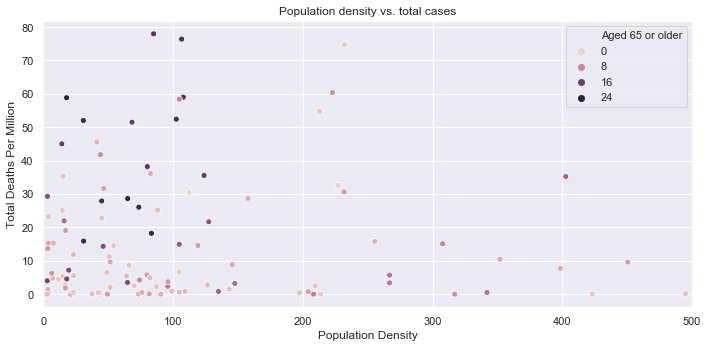

In [10]:
complete_data.head()

sns.set()
with sns.color_palette("hls", 8):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data = complete_data, x = "Population Density", y = "Total Deaths Per Million", hue = "Aged 65 or older")
    plt.title("Population density vs. total cases")
    plt.xlim(0,500)
    plt.tight_layout()
    
complete_data.head()